In [1]:
%matplotlib widget

In [2]:
# assume working in Jupyter Lab
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../pywed')
sys.path.append('../IRFMtb')

import pywed as pw
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (8,5)

from control_room import *
from pulse_database import PulseDB

import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

from scipy.optimize import curve_fit 
from tqdm import tqdm

IMAS only available on linux machines


# Importing the database

In [4]:
# Importing Resumed Parameters
data = pd.read_csv('WEST_C4_database_resumed_parameters.csv')
data.head()

,Unnamed: 0,pulse,Ag18,Ag19,Cu,year,month,day,freq_Q1,freq_Q2,...,Prad,Prad_bulk,Rext_lower,Rext_lower_NICE,Rext_median,Rext_median_NICE,Rext_upper,Rext_upper_NICE,Separatrix_P,nl
0,0,54404,0.0,0.0,NaN,2019.0,7.0,16.0,55.5,55.689999,...,NaN,NaN,2812.571429,2.808633,2992.938776,2.944822,2931.816327,2.894968,NaN,NaN
1,1,54404,0.0,0.0,NaN,2019.0,7.0,16.0,55.5,55.689999,...,NaN,NaN,2857.551020,2.880549,2921.122449,2.959408,2852.285714,2.916914,-0.027970,1.189777
2,2,54404,0.0,0.0,NaN,2019.0,7.0,16.0,55.5,55.689999,...,0.130761,0.128938,2871.816327,2.827263,2936.836735,2.906623,2881.877551,2.859345,NaN,1.202949
3,3,54404,0.0,0.0,NaN,2019.0,7.0,16.0,55.5,55.689999,...,0.087718,0.085613,2870.448980,2.891742,2940.877551,2.976342,2885.816327,2.943252,NaN,1.255339
4,4,54404,0.0,0.0,1.273619,2019.0,7.0,16.0,55.5,55.689999,...,0.076202,0.073030,2866.163265,2.881724,2933.734694,2.961178,2876.367347,2.926255,0.529017,1.281202


In [5]:
# create the date from the key year/month/day
data['date'] = pd.to_datetime(dict(year=data['year'], month=data['month'], day=data['day']))

# Power and requests

In [6]:
data.columns

Index(['Unnamed: 0', 'pulse', 'Ag18', 'Ag19', 'Cu', 'year', 'month', 'day',
       'freq_Q1', 'freq_Q2',
       ...
       'Prad_bulk', 'Rext_lower', 'Rext_lower_NICE', 'Rext_median',
       'Rext_median_NICE', 'Rext_upper', 'Rext_upper_NICE', 'Separatrix_P',
       'nl', 'date'],
      dtype='object', length=107)

In [7]:
data['IC_Vmax_Q4'] = data[['IC_Voltage_left_upper_Q4', 'IC_Voltage_right_upper_Q4', 
                           'IC_Voltage_left_lower_Q4', 'IC_Voltage_right_lower_Q4',]].max(axis=1)

In [8]:
data['IC_P_Gen1_fwd'] = data['IC_P_Gen1'] + data['IC_P_Gen1_ref']
data['IC_P_Gen2_fwd'] = data['IC_P_Gen2'] + data['IC_P_Gen2_ref']
data['IC_P_Gen3_fwd'] = data['IC_P_Gen3'] + data['IC_P_Gen3_ref']
data['IC_P_Gen4_fwd'] = data['IC_P_Gen4'] + data['IC_P_Gen4_ref']
data['IC_P_Gen5_fwd'] = data['IC_P_Gen5'] + data['IC_P_Gen5_ref']
data['IC_P_Gen6_fwd'] = data['IC_P_Gen6'] + data['IC_P_Gen6_ref']

data['IC_P_Gen_Q1'] = data['IC_P_Gen5'] + data['IC_P_Gen6']
data['IC_P_Gen_Q2'] = data['IC_P_Gen1'] + data['IC_P_Gen2']
data['IC_P_Gen_Q4'] = data['IC_P_Gen3'] + data['IC_P_Gen4']


data['IC_Q1_Rc_left_over_right'] = data['IC_Rc_Q1_left']/data['IC_Rc_Q1_right']
data['IC_Q2_Rc_left_over_right'] = data['IC_Rc_Q2_left']/data['IC_Rc_Q2_right']
data['IC_Q4_Rc_left_over_right'] = data['IC_Rc_Q4_left']/data['IC_Rc_Q4_right']


KeyError: 'IC_Rc_Q1_left'

# Derived quantities

In [9]:
data['IC_Q1_Vmax'] = data[['IC_Voltage_left_lower_Q1', 'IC_Voltage_right_lower_Q1','IC_Voltage_right_upper_Q1','IC_Voltage_left_upper_Q1']].max(axis=1)
data['IC_Q2_Vmax'] = data[['IC_Voltage_left_lower_Q2', 'IC_Voltage_right_lower_Q2','IC_Voltage_right_upper_Q2','IC_Voltage_left_upper_Q2']].max(axis=1)
data['IC_Q4_Vmax'] = data[['IC_Voltage_left_lower_Q4', 'IC_Voltage_right_lower_Q4','IC_Voltage_right_upper_Q4','IC_Voltage_left_upper_Q4']].max(axis=1)

In [10]:
data['Ptot'] = data['Ohmic_P'] + data['LH_P_tot'] + data['IC_P_tot']/1e3
data['P_conv'] = data['Ptot'] - data['Prad']
data['frad'] = data['Prad']/data['Ptot']
data['frad_bulk'] = data['Prad_bulk']/data['Ptot']

In [11]:
data['ROG_Q1'] = data['R_Q1']*1e3 - data['Rext_median']
data['ROG_Q2'] = data['R_Q2']*1e3 - data['Rext_median']
data['ROG_Q4'] = data['R_Q4']*1e3 - data['Rext_median']
data['ROG'] = data[['R_Q1', 'R_Q2', 'R_Q4']].min(axis=1)*1e3 - data['Rext_median']

In [12]:
data['P_conv_ratio'] = data['P_conv']/(data['IC_P_tot']*1e-3)

In [13]:
# Define USN.LSN plasma configuration
data['Xpoint'] = 'LSN'  # default plasma are LSN, only a few listed below are USN
USN_list = np.r_[55227, 55174, 55173, 55172, 55171, 55170]
USN_list = np.append(USN_list, np.arange(54882, 54892))
USN_list = np.append(USN_list, np.arange(54894, 54903))
USN_list = np.append(USN_list, np.load('USN_pulse.npy'))  # List by J.Morales
USN_list = np.unique(USN_list)
print(USN_list)
data.loc[data['pulse'].isin(USN_list), 'Xpoint'] = 'USN'

[54882 54883 54884 54885 54886 54887 54888 54889 54890 54891 54894 54895
 54896 54897 54898 54899 54900 54901 54902 54976 54977 54978 54982 54984
 54986 54987 54989 54991 55000 55001 55002 55004 55006 55008 55170 55171
 55172 55173 55174 55227 55568 55599 55600 55601 55602 55603 55604 55606
 55607 55610 55614 55621 55628 55635 55636 55638 55639 55640 55643 55644
 55646 55647 55648 55651 55652 55656 55657 55659 55662 55675 55684 55686
 55687 55688 55728 55733 55736 55780 55781 55782 55783 55784 55785 55786
 55787 55789 55790 55791 55792 55794]


In [14]:
data['Lang_LH1_avg'] = (data['Langmuir_LHCD1'] + data['Langmuir_LHCD2'] + data['Langmuir_LHCD4'])/3
data['Lang_LH2_avg'] = (data['Langmuir_LHCD5'] + data['Langmuir_LHCD6'] + data['Langmuir_LHCD7'] + data['Langmuir_LHCD8'])/4
data['ne_LH1_sur_nl'] = data['Lang_LH1_avg'] / data['nl']
data['ne_LH2_sur_nl'] = data['Lang_LH2_avg'] / data['nl']

# Langmuir Probes

In [18]:
P_min = 0.5e3
Xpoint = "LSN"
Ip_min = 480
Ip_max = 520
nl_min = 3.0
nl_max = 4.0
phase_min=160
phase_max = 200
Rext_median_max = 2960
ROG = np.linspace(-10, 40, 20)
P_LH_max = 5

fig, ax = plt.subplots(figsize=(8,6))

LH_antenna = 'LH1'

dataset = data.query('IC_P_tot < 50 and LH_P_tot > 1')\
            .query('Xpoint=="LSN"')\
            .query('ROG_Q1 > -10 and ROG_Q1 < 100')\
            .query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('MHD < 100')
    
if LH_antenna == 'LH1':
    dataset.plot(ax=ax, kind='scatter', x='LH_P_tot', y='ne_LH1_sur_nl', c='MHD', cmap='winter', s=20, alpha=0.5, label='LH1')
else:
    dataset.plot(ax=ax, kind='scatter', x='LH_P_tot', y='ne_LH2_sur_nl', c='MHD', cmap='winter', s=20, alpha=0.5, label='LH2')

ax.set_ylim(0,4)
ax.set_xlabel('LH Power [MW]', fontsize=16)
ax.set_ylabel('$I_{sat,LH}/n_l$ [a.u]', fontsize=16)
ax.set_title(f'{LH_antenna} Langmuir Probes, IC Power < 100 kW \n LSN plasmas - $n_l\in$ [{nl_min};{nl_max}] - $I_p\in$ [{Ip_min};{Ip_max}] -\n  Rext<{Rext_median_max/1e3}m', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Role of the outer gap distance

In [19]:
def Rc_theoretical(x, lambd, A):
    return A*np.exp(-x/lambd)

In [20]:
P_min = 0.5e3
Xpoint = "LSN"
Ip_min = 480
Ip_max = 520
nl_min = 3.0
nl_max = 4.0
phase_min=160
phase_max = 200
Rext_median_max = 2960
ROG = np.linspace(-10, 40, 20)
P_LH_max = 5


fig, ax = plt.subplots()

data_Q1 = data.query('IC_P_Q2 < 100 and IC_P_Q4 < 100 and LH_P_tot < @P_LH_max and Rext_median < @Rext_median_max and ROG_Q1 > -10 and ROG_Q1 < 100 and IC_P_Q1 > @P_min and IC_Phase_Q1 > @phase_min and IC_Phase_Q1 < @phase_max and Xpoint == @Xpoint and Ip > @Ip_min and Ip < @Ip_max and nl > @nl_min and nl < @nl_max').dropna(subset = ['ROG_Q1', 'IC_Rc_Q1_avg'])
data_Q1.plot(ax=ax, kind='scatter', x='ROG_Q1', y='IC_Rc_Q1_avg', label='Q1', color='C0', alpha=0.2)

data_Q2 = data.query('IC_P_Q1 < 100 and IC_P_Q4 < 100 and LH_P_tot < @P_LH_max and Rext_median < @Rext_median_max and ROG_Q2 > -10 and ROG_Q2 < 100 and IC_P_Q2 > @P_min  and IC_Phase_Q2 > @phase_min and IC_Phase_Q2 < @phase_max and pulse > 55145 and Xpoint == @Xpoint and Ip > @Ip_min and Ip < @Ip_max and nl > @nl_min and nl < @nl_max').dropna(subset = ['ROG_Q2', 'IC_Rc_Q2_avg'])
data_Q2.plot(ax=ax, kind='scatter', x='ROG_Q2', y='IC_Rc_Q2_avg', label='Q2', color='C1', alpha=0.2)

data_Q4 = data.query('IC_P_Q1 < 100 and IC_P_Q2 < 100 and LH_P_tot < @P_LH_max and Rext_median < @Rext_median_max and ROG_Q4 > -10 and ROG_Q4 < 100 and IC_P_Q4 > @P_min  and IC_Phase_Q4 > @phase_min and IC_Phase_Q4 < @phase_max and Xpoint == @Xpoint and Ip > @Ip_min and Ip < @Ip_max and nl > @nl_min and nl < @nl_max').dropna(subset = ['ROG_Q4', 'IC_Rc_Q4_avg'])
data_Q4.plot(ax=ax, kind='scatter', x='ROG_Q4', y='IC_Rc_Q4_avg', label='Q4', color='C2', alpha=0.2)

ax.set_ylim(0.5,3)
ax.set_xlim(-10, 50)
ax.set_yscale('log')
ax.set_title(f'WEST C4 - $P>${P_min} kW - LSN plasmas - $n_l\in$ [{nl_min};{nl_max}] - $I_p\in$ [{Ip_min};{Ip_max}] -\n  P_LH<{P_LH_max}MW - Rext<{Rext_median_max/1e3}m')

fit, sigma = curve_fit(Rc_theoretical, data_Q1['ROG_Q1'].values, data_Q1['IC_Rc_Q1_avg'].values, p0=(60,1))
ax.plot(ROG, Rc_theoretical(ROG, *fit), color='C0')
fit, sigma = curve_fit(Rc_theoretical, data_Q2['ROG_Q2'].values, data_Q2['IC_Rc_Q2_avg'].values, p0=(60,1))
ax.plot(ROG, Rc_theoretical(ROG, *fit), color='C1')
fit, sigma = curve_fit(Rc_theoretical, data_Q4['ROG_Q4'].values, data_Q4['IC_Rc_Q4_avg'].values, p0=(60,1))
ax.plot(ROG, Rc_theoretical(ROG, *fit), color='C2')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
fig, ax = plt.subplots()
data_Q1.plot(kind='scatter', x='ROG_NICE', y='frad', ax=ax, color='C0', alpha=0.2)
data_Q2.plot(kind='scatter', x='ROG_NICE', y='frad', ax=ax, color='C1', alpha=0.2)
data_Q4.plot(kind='scatter', x='ROG_NICE', y='frad', ax=ax, color='C2', alpha=0.2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyError: 'ROG_NICE'

In [22]:
fig, ax = plt.subplots()
data.query('Ip < 650 and Ip > 550').\
plot(ax=ax, kind='hist', y='nl', bins=50)
fig.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Phase Scan in #55226

In [ ]:
data['Q2 V1-V2'] = np.abs(data['IC_Voltage_left_upper_Q2'] - data['IC_Voltage_left_lower_Q2'])
data['Q2 V3-V4'] = np.abs(data['IC_Voltage_right_upper_Q2'] - data['IC_Voltage_right_lower_Q2'])

data['Q4 V1-V2'] = np.abs(data['IC_Voltage_left_upper_Q4'] - data['IC_Voltage_left_lower_Q4'])
data['Q4 V3-V4'] = np.abs(data['IC_Voltage_right_upper_Q4'] - data['IC_Voltage_right_lower_Q4'])

data['IC_Q2_tuning_quality'] = np.abs(data['Q2 V1-V2'] - data['Q2 V3-V4']) 
data['IC_Q4_tuning_quality'] = np.abs(data['Q4 V1-V2'] - data['Q4 V3-V4']) 

In [ ]:
pulse55226 = data.query('pulse == 55226')

(10.0, 22.0)

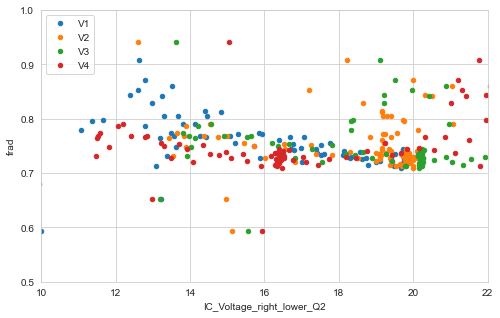

In [19]:
fig, ax = plt.subplots()
y='frad'
pulse55226.plot(ax=ax, kind='scatter', x='IC_Voltage_left_upper_Q2', y=y, color='C0', label='V1')
pulse55226.plot(ax=ax, kind='scatter', x='IC_Voltage_left_lower_Q2', y=y, color='C1', label='V2')
pulse55226.plot(ax=ax, kind='scatter', x='IC_Voltage_right_upper_Q2', y=y, color='C2', label='V3')
pulse55226.plot(ax=ax, kind='scatter', x='IC_Voltage_right_lower_Q2', y=y, color='C3', label='V4')

ax.set_ylim(0.5,1)
ax.set_xlim(10,22)

(0.5, 1.0)

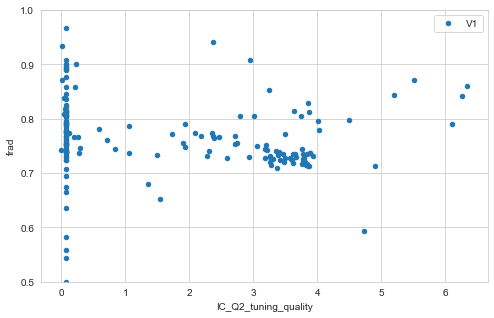

In [20]:
fig, ax = plt.subplots()
y='frad'
pulse55226.plot(ax=ax, kind='scatter', x='IC_Q2_tuning_quality', y=y, color='C0', label='V1')
ax.set_ylim(0.5,1)

(0.0, 1.0)

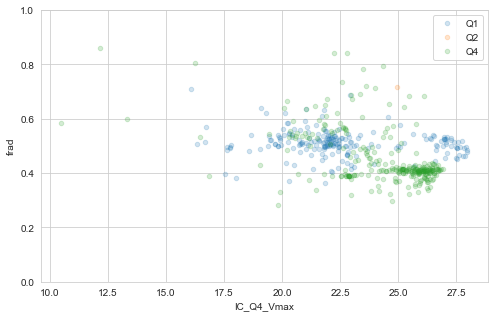

In [21]:
fig, ax = plt.subplots()
data.query('IC_P_Q1 > 500 and IC_P_Q2 < 100 and IC_P_Q4 < 100 and Ip < 550 and Xpoint == "USN" and nl > 3.9 and nl < 4.5').\
plot(ax=ax, kind='scatter', x='IC_Q1_Vmax', y='frad', label='Q1', alpha=0.2, color='C0')

data.query('IC_P_Q2 > 500 and IC_P_Q1 < 100 and pulse > 55145 and IC_P_Q4 < 100 and Ip < 550 and Xpoint == "USN" and nl > 3.9 and nl < 4.5').\
plot(ax=ax, kind='scatter', x='IC_Q2_Vmax', y='frad', label='Q2', alpha=0.2, color='C1')

data.query('IC_P_Q4 > 500 and IC_P_Q2 < 100 and IC_P_Q1 < 100 and Ip < 550 and Xpoint == "USN" and nl > 3.9 and nl < 4.5').\
plot(ax=ax, kind='scatter', x='IC_Q4_Vmax', y='frad', label='Q4', alpha=0.2, color='C2')

ax.set_ylim(0,1)

(0.0, 1.5)

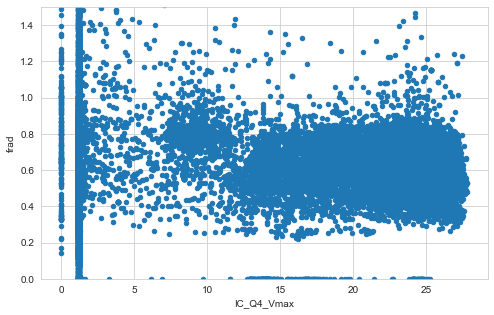

In [22]:
fig, ax = plt.subplots()
data.plot(ax=ax, kind='scatter', x='IC_Q4_Vmax', y='frad')
ax.set_ylim(0,1.5)

# Coupling Statistics

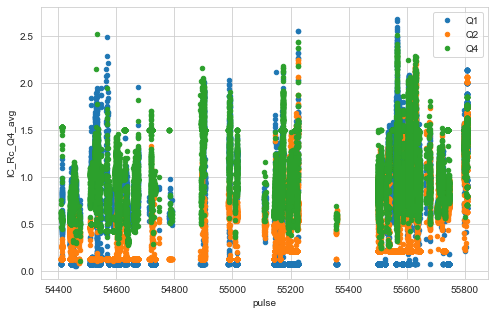

In [23]:
fig, ax = plt.subplots()
data.query('IC_P_tot > 400').plot(ax=ax, kind='scatter', x='pulse', y='IC_Rc_Q1_avg', label='Q1', color='C0')
data.query('IC_P_tot > 400').plot(ax=ax, kind='scatter', x='pulse', y='IC_Rc_Q2_avg', label='Q2', color='C1')
data.query('IC_P_tot > 400').plot(ax=ax, kind='scatter', x='pulse', y='IC_Rc_Q4_avg', label='Q4', color='C2')

In [24]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN" and Ip < 600')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > 55145 and Xpoint == "LSN" and Ip < 600')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN" and Ip < 600')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2 (>#55145)', '', 'Q4'))
ax.tick_params(labelsize=15)
ax.set_title('WEST C4 (P>400kW, 500kA, LSN)', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ylim = ax.set_ylim()

# Add secondary y axis with max coupling power vs coupling resistance
# 1.5 Ohm -> 2 MW
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Coupled Power you can hope for [MW]', color=color, fontsize=12)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.set_yticks(2/1.5*ax.get_yticks())
ax2.grid(None)
ax.set_ylim(0,3)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 3.0)

In [25]:
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_500kA.png', dpi=150)

AttributeError: 'NoneType' object has no attribute '_send_event'

In [27]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "USN" and Ip < 600')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > 55145 and Xpoint == "USN" and Ip < 600')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "USN" and Ip < 600')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2 (>#55145)', '', 'Q4'))
ax.tick_params(labelsize=15)
ax.set_title('WEST C4 (P>400kW, 500kA, USN)', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)

# Add secondary y axis with max coupling power vs coupling resistance
# 1.5 Ohm -> 2 MW
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Coupled Power you can hope for [MW]', color=color, fontsize=12)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.set_yticks(2/1.5*ax.get_yticks())
ax2.grid(None)
ax.set_ylim(0,3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 3.0)

In [26]:
fig.savefig('WEST_C4_IC_Rc_distribution_USN_500kA.png', dpi=150)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'NoneType' object has no attribute '_send_event'

In [28]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN" and Ip < 600')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > 55145 and Xpoint == "LSN"  and Ip < 600')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN" and Ip < 600')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "USN" and Ip < 600')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > 55145 and Xpoint == "USN" and Ip < 600')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "USN" and Ip < 600')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2 (>#55145)', '', 'Q4'))
ax.tick_params(labelsize=15)
ax.set_title('WEST C4 (P>400kW, 500kA, LSN vs USN)', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(0,3)

# Add secondary y axis with max coupling power vs coupling resistance
# 1.5 Ohm -> 2 MW
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Coupled Power you can hope for [MW]', color=color, fontsize=12)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.set_yticks(2/1.5*ax.get_yticks())
ax2.grid(None)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

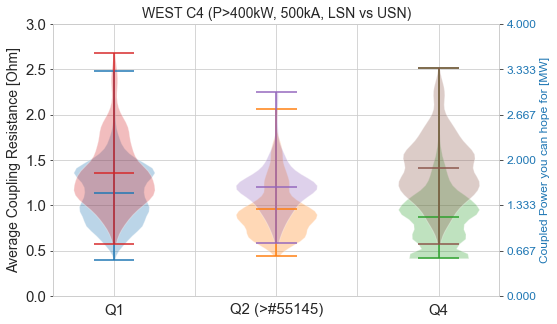

In [27]:
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_vs_USN_500kA.png', dpi=150)

In [29]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN" and Ip > 600')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > 55145 and Xpoint == "LSN"  and Ip > 600')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN" and Ip > 600')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

fig.savefig('WEST_C4_IC_Rc_distribution_LSN_700kA.png', dpi=150)

#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2 (>#55145)', '', 'Q4'))
ax.tick_params(labelsize=15)
ax.set_title('WEST C4 (P>400kW, 700kA, LSN vs USN)', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(0,3)

# Add secondary y axis with max coupling power vs coupling resistance
# 1.5 Ohm -> 2 MW
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Coupled Power you can hope for [MW]', color=color, fontsize=12)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.set_yticks(2/1.5*ax.get_yticks())
ax2.grid(None)

ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "USN" and Ip > 600')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > 55145 and Xpoint == "USN" and Ip > 600')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "USN" and Ip > 600')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

fig.savefig('WEST_C4_IC_Rc_distribution_LSN_vs_USN_700kA.png', dpi=150)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'NoneType' object has no attribute '_send_event'

Taking the maximum power per plasma pulse

# Why does USN plasma increase coupling?

In [30]:
fig, ax = plt.subplots()
data.query('IC_P_Q4 > 600 and Xpoint == "LSN" and Ip < 550').plot(ax=ax, c='C0', kind='scatter', x='ROG_Q4', y='IC_Rc_Q4_avg', alpha=0.2)
data.query('IC_P_Q4 > 600 and Xpoint == "USN" and Ip < 550').plot(ax=ax, c='C1', kind='scatter', x='ROG_Q4', y='IC_Rc_Q4_avg', alpha=0.2)
ax.set_xlim(-10, 40)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-10.0, 40.0)

# Coupling Improvement with LH

## 500 kA, USN

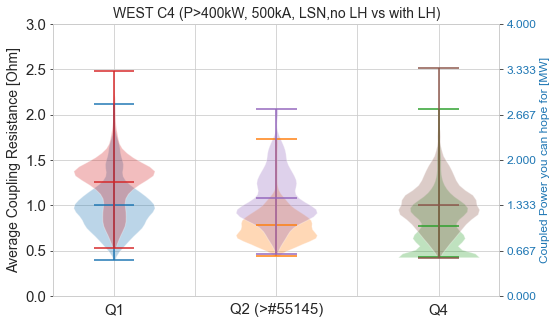

In [30]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN" and Ip < 600 and LH_P_tot < 0.1' )['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > 55145 and Xpoint == "LSN"  and Ip < 600  and LH_P_tot < 0.1')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN" and Ip < 600 and LH_P_tot < 0.1')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')


#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2 (>#55145)', '', 'Q4'))
ax.tick_params(labelsize=15)
ax.set_title('WEST C4 (P>400kW, 500kA, LSN, no LH )', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(0,3)

# Add secondary y axis with max coupling power vs coupling resistance
# 1.5 Ohm -> 2 MW
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Coupled Power you can hope for [MW]', color=color, fontsize=12)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.set_yticks(2/1.5*ax.get_yticks())
ax2.grid(None)

fig.savefig('WEST_C4_IC_Rc_distribution_noLH_500kA.png', dpi=150)

ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN" and Ip < 600 and LH_P_tot > 0.2')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > 55145 and Xpoint == "LSN"  and Ip < 600  and LH_P_tot > 0.2')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN" and Ip < 600 and LH_P_tot > 0.2')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_title('WEST C4 (P>400kW, 500kA, LSN,no LH vs with LH)', fontsize=14)
fig.savefig('WEST_C4_IC_Rc_distribution_noLH_vs_LH_500kA.png', dpi=150)

## 700 kA, LSN

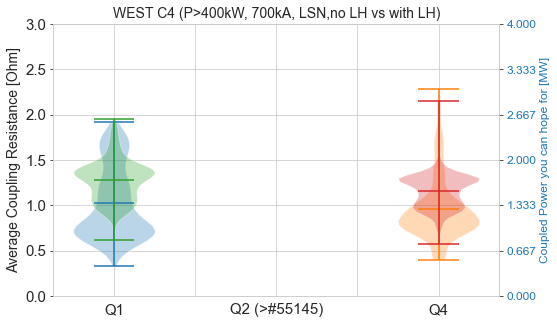

In [31]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN" and Ip > 650 and LH_P_tot < 0.1' )['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN" and Ip > 650 and LH_P_tot < 0.1')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')


#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2 (>#55145)', '', 'Q4'))
ax.tick_params(labelsize=15)
ax.set_title('WEST C4 (P>400kW, 700kA, LSN, no LH )', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(0,3)

# Add secondary y axis with max coupling power vs coupling resistance
# 1.5 Ohm -> 2 MW
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Coupled Power you can hope for [MW]', color=color, fontsize=12)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.set_yticks(2/1.5*ax.get_yticks())
ax2.grid(None)

fig.savefig('WEST_C4_IC_Rc_distribution_noLH_700kA_LSN.png', dpi=150)

ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN" and Ip > 650 and LH_P_tot > 0.2')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN" and Ip > 650 and LH_P_tot > 0.2')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_title('WEST C4 (P>400kW, 700kA, LSN,no LH vs with LH)', fontsize=14)
fig.savefig('WEST_C4_IC_Rc_distribution_noLH_vs_LH_700kA_LSN.png', dpi=150)

## 500 kA, USN

In [32]:
data.query('IC_P_Q1 > 400 and Xpoint == "USN" and Ip < 600 and LH_P_tot < 0.1' )['pulse'].unique()

array([54897, 54898, 54899, 54900, 54902, 54987, 54989, 54991, 55174,
       55227, 55600, 55602, 55603, 55604, 55614], dtype=int64)

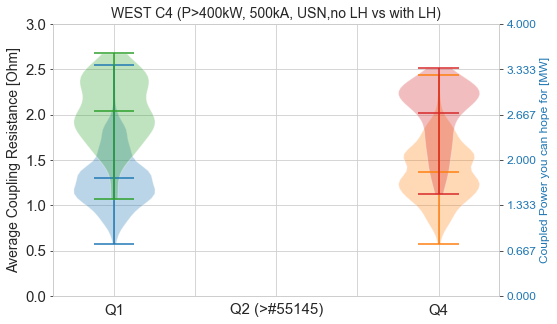

In [33]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "USN" and Ip < 600 and LH_P_tot < 0.1' )['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "USN" and Ip < 600 and LH_P_tot < 0.1')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')


#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2 (>#55145)', '', 'Q4'))
ax.tick_params(labelsize=15)
ax.set_title('WEST C4 (P>400kW, 500kA, USN, no LH )', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(0,3)

# Add secondary y axis with max coupling power vs coupling resistance
# 1.5 Ohm -> 2 MW
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Coupled Power you can hope for [MW]', color=color, fontsize=12)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.set_yticks(2/1.5*ax.get_yticks())
ax2.grid(None)

fig.savefig('WEST_C4_IC_Rc_distribution_noLH_500kA_USN.png', dpi=150)

ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "USN" and Ip < 600 and LH_P_tot > 0.2')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')


ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "USN" and Ip < 600 and LH_P_tot > 0.2')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_title('WEST C4 (P>400kW, 500kA, USN,no LH vs with LH)', fontsize=14)
fig.savefig('WEST_C4_IC_Rc_distribution_noLH_vs_LH_500kA_USN.png', dpi=150)

## 700 kA, USN

not enought data

# Max Power Statistics

In [39]:
data_max_power = data.query('IC_P_tot > 0 and year>=2019').groupby('pulse').max()
data_max_power['P'] = data_max_power['IC_P_tot']/1e3

In [40]:
data_max_power=data_max_power.reset_index()  # create a counter of plasma

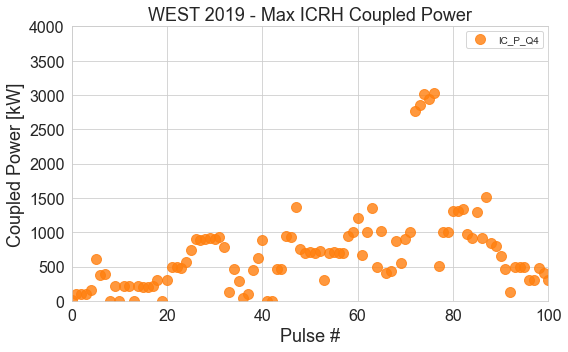

In [41]:
fig, ax = plt.subplots()

data_max_power.plot(y='IC_P_Q4', marker='.', ms=20, ls='', ax=ax, alpha=.8, c='C1')

ax.set_xlabel('Pulse #', fontsize=18)
ax.set_ylabel('Coupled Power [kW]', fontsize=18)
ax.tick_params(labelsize=16)
ax.set_ylim(0,4000)
ax.set_xlim(0,100)
#ax.axhline(1.2, color='k', alpha=0.5, ls='--', lw=2)
ax.set_title('WEST 2019 - Max ICRH Coupled Power', fontsize=18)
fig.tight_layout()

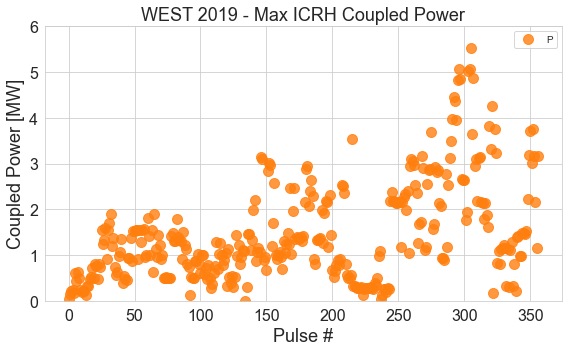

In [42]:
fig, ax = plt.subplots()

data_max_power.plot(y='P', marker='.', ms=20, ls='', ax=ax, alpha=.8, c='C1')

ax.set_xlabel('Pulse #', fontsize=18)
ax.set_ylabel('Coupled Power [MW]', fontsize=18)
ax.tick_params(labelsize=16)
ax.set_ylim(0,6)
#ax.axhline(1.2, color='k', alpha=0.5, ls='--', lw=2)
ax.set_title('WEST 2019 - Max ICRH Coupled Power', fontsize=18)
fig.tight_layout()

#fig.savefig('WEST_C4_ICRH_max_power.png', dpi=150)

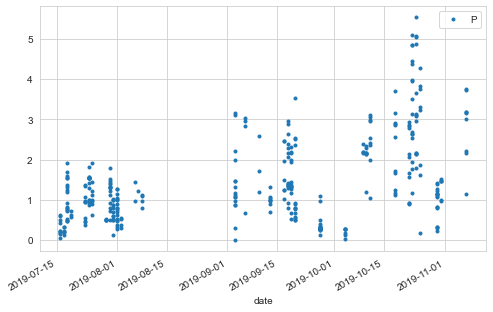

In [43]:
data_max_power.plot(x='date', y='P', marker='.', ls='')

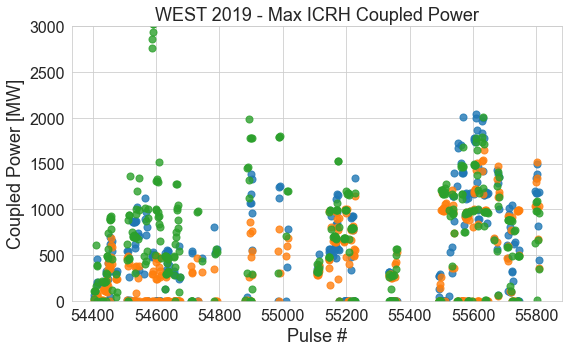

In [44]:
fig, ax = plt.subplots()

data_max_power.plot(kind='scatter', x='pulse', y='IC_P_Q1', s=50, ax=ax, alpha=.8, c='C0')
data_max_power.plot(kind='scatter', x='pulse', y='IC_P_Q2', s=50, ax=ax, alpha=.8, c='C1')
data_max_power.plot(kind='scatter', x='pulse', y='IC_P_Q4', s=50, ax=ax, alpha=.8, c='C2')

ax.set_xlabel('Pulse #', fontsize=18)
ax.set_ylabel('Coupled Power [MW]', fontsize=18)
ax.tick_params(labelsize=16)
ax.set_ylim(0,3000)
#ax.axhline(1.2, color='k', alpha=0.5, ls='--', lw=2)
ax.set_title('WEST 2019 - Max ICRH Coupled Power', fontsize=18)
fig.tight_layout()

#fig.savefig('WEST_C4_ICRH_max_power_vs_date.png', dpi=150)

# radiated power statistics

<IPython.core.display.Javascript object>


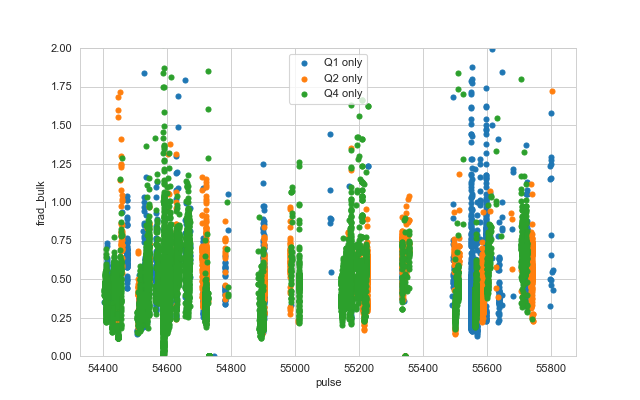

(0, 2)

In [21]:
fig, ax = plt.subplots()
data.query('IC_P_Q1 > 100 and IC_P_Q2 < 100 and IC_P_Q4 < 100').plot(kind='scatter', x='pulse', y='frad_bulk', color='C0', label='Q1 only', ax=ax)
data.query('IC_P_Q1 < 100 and IC_P_Q2 > 100 and IC_P_Q4 < 100').plot(kind='scatter', x='pulse', y='frad_bulk', color='C1', label='Q2 only', ax=ax)
data.query('IC_P_Q1 < 100 and IC_P_Q2 < 100 and IC_P_Q4 > 100').plot(kind='scatter', x='pulse', y='frad_bulk', color='C2', label='Q4 only', ax=ax)
ax.set_ylim(0, 2)

<IPython.core.display.Javascript object>


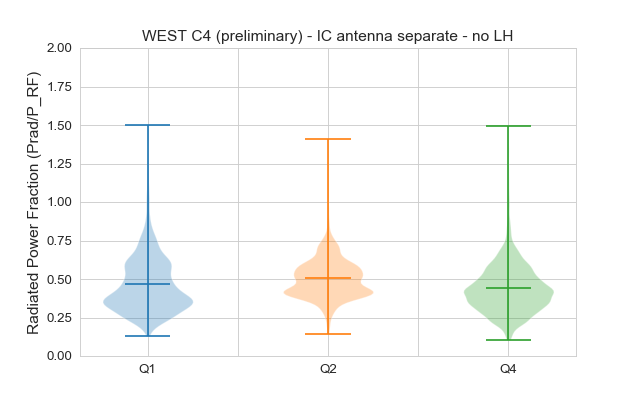

In [22]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 100 and IC_P_Q2 < 100 and IC_P_Q4 < 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [0],  widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 < 100 and IC_P_Q2 > 100 and IC_P_Q4 < 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [1], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 < 100 and IC_P_Q2 < 100 and IC_P_Q4 > 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [2], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Radiated Power Fraction (Prad/P_RF)', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) - IC antenna separate - no LH', fontsize=14)
ax.grid(True)
ax.set_ylim(0,2)

fig.savefig('WEST_C4_IC_frad_vs_antenna.png', dpi=150)

<IPython.core.display.Javascript object>


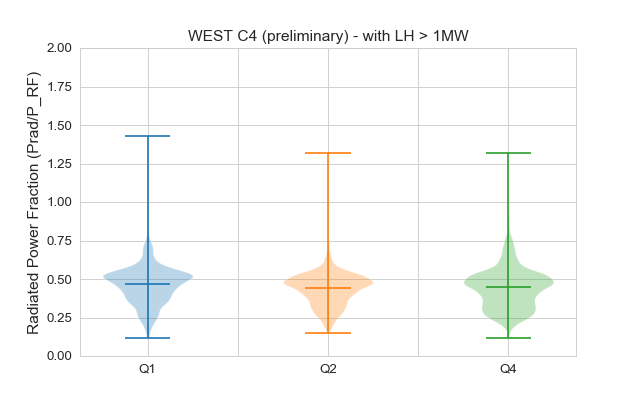

In [23]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot > 1 and IC_P_Q1 > 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [0],  widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 1 and IC_P_Q2 > 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [1], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 1 and IC_P_Q4 > 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [2], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Radiated Power Fraction (Prad/P_RF)', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) - with LH > 1MW', fontsize=14)
ax.grid(True)
ax.set_ylim(0,2)

fig.savefig('WEST_C4_IC_frad_vs_antenna_with_LH.png', dpi=150)

<IPython.core.display.Javascript object>


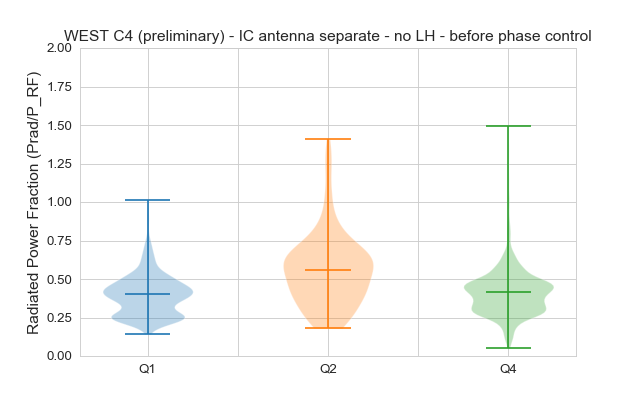

(0, 2)

In [16]:
pulse_ref = 54626
                        
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse < @pulse_ref and IC_P_Q1 > 100 and IC_P_Q2 < 100 and IC_P_Q4 < 100 and frad_bulk > 0.05 and frad_bulk < 1.5')['frad_bulk'].dropna(), [0],  widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse < @pulse_ref and IC_P_Q1 < 100 and IC_P_Q2 > 100 and IC_P_Q4 < 100 and frad_bulk > 0.05 and frad_bulk < 1.5')['frad_bulk'].dropna(), [1], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse < @pulse_ref and IC_P_Q1 < 100 and IC_P_Q2 < 100 and IC_P_Q4 > 100 and frad_bulk > 0.05 and frad_bulk < 1.5')['frad_bulk'].dropna(), [2], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Radiated Power Fraction (Prad/P_RF)', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) - IC antenna separate - no LH - before phase control', fontsize=14)
ax.grid(True)
ax.set_ylim(0,2)
                         

<IPython.core.display.Javascript object>


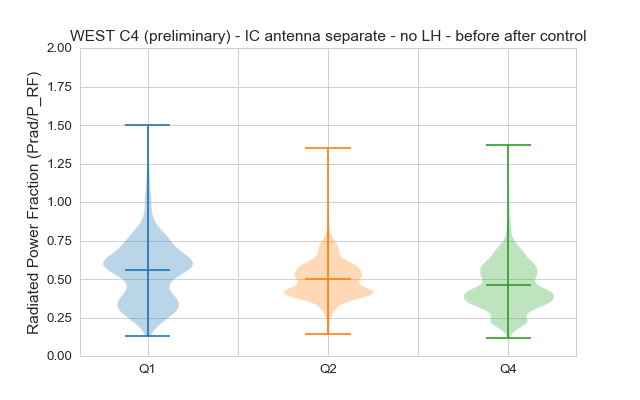

(0, 2)

In [24]:
pulse_ref = 54626
                        
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse > 55525 and IC_P_Q1 > 100 and IC_P_Q2 < 100 and IC_P_Q4 < 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [0],  widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse > @pulse_ref and IC_P_Q1 < 100 and IC_P_Q2 > 100 and IC_P_Q4 < 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [1], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and pulse > @pulse_ref and IC_P_Q1 < 100 and IC_P_Q2 < 100 and IC_P_Q4 > 100 and frad_bulk > 0.1 and frad_bulk < 1.5')['frad_bulk'].dropna(), [2], widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Radiated Power Fraction (Prad/P_RF)', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) - IC antenna separate - no LH - before after control', fontsize=14)
ax.grid(True)
ax.set_ylim(0,2)

# Link between radiated power and LCFS radius

In [25]:
data.query('IC_P_tot > 500 and P_conv > 0.5')['P_conv'].min()

0.5000025928005768

<IPython.core.display.Javascript object>


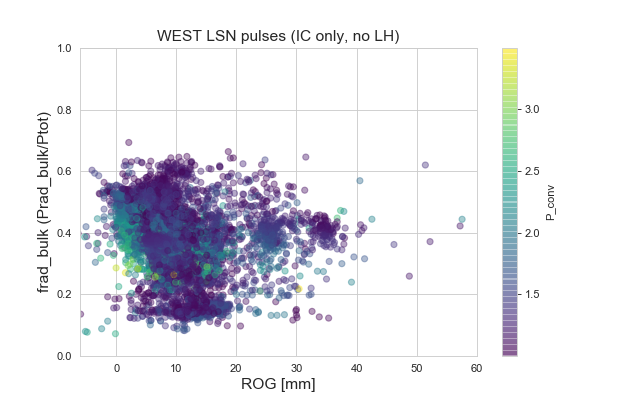

Text(0.5, 1.0, 'WEST LSN pulses (IC only, no LH)')

In [26]:
fig, ax = plt.subplots()
data.query('IC_P_tot > 500 and LH_P_tot < 0.1 and P_conv > 1 and frad > 0.05 and Xpoint == "LSN"').\
    plot(kind='scatter', x='ROG_Q4', y='frad_bulk', ax=ax,
    c='P_conv', cmap='viridis', alpha=0.4, s=30)
ax.set_xlim(-6, 60)
ax.set_ylim(0, 1)
ax.set_xlabel('ROG [mm]', fontsize=14)
ax.set_ylabel('frad_bulk (Prad_bulk/Ptot)', fontsize=14)
ax.set_title('WEST LSN pulses (IC only, no LH)', fontsize=14)

In [ ]:
data.query('IC_P_Q4 > 300 and LH_P_tot > 0.1 and Xpoint == "LSN"').\
    plot(kind='scatter', x='LH_P_tot', y='IC_Rc_Q4_avg', 
         alpha=0.2, c='Rext_median', cmap='viridis')

# Shot-Averaged parameters
Here we average the dataset for each shot, in order to seek for specific shot-behaviour.

In [27]:
exclude = [54587,54588,54589,54590,54591]
query = 'IC_P_Q4 > 500 and pulse not in @exclude and LH_P_tot < 0.1'# and IC_P_Q1 < 50 and IC_P_Q2 < 50'
pulse_mean = data.query(query).groupby(['pulse']).mean()
pulse_std = data.query(query).groupby(['pulse']).std()
pulse_max = data.query(query).groupby(['pulse']).max()
pulses = pulse_mean.index

<IPython.core.display.Javascript object>


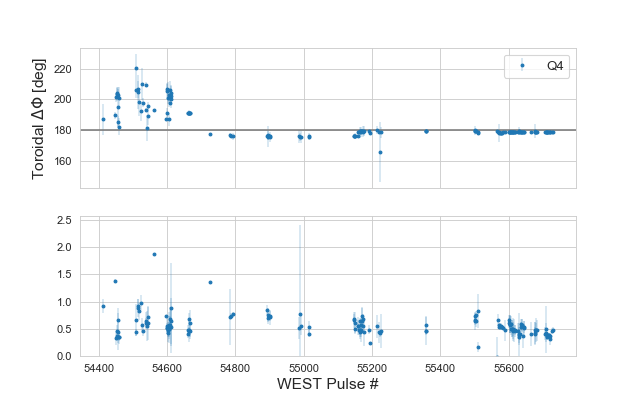

In [28]:
def plot_errorbar(sig_name, axe, label=None):
    markers, caps, bars = axe.errorbar(pulses, 
                                  pulse_mean[sig_name], 
                                  yerr=pulse_std[sig_name], 
                                  ls='', marker='.', ms=5, label=label)
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.2) for bar in bars]

fig, ax = plt.subplots(2, 1, sharex=True)
#plot_errorbar('IC_delta_phi_toro_Q1_Bot_LmR', ax[0], label='Q1')
#plot_errorbar('IC_delta_phi_toro_Q2_Top_LmR', ax[0], label='Q2')
plot_errorbar('IC_delta_phi_toro_Q4_Top_LmR', ax[0], label='Q4')

plot_errorbar('P_conv_ratio', ax[1])
ax[1].set_ylim(bottom=0)

ax[0].axhline(180, color='gray')
ax[-1].set_xlabel('WEST Pulse #', fontsize=14)
ax[0].set_ylabel('Toroidal $\Delta \Phi$ [deg]', fontsize=14)
ax[0].legend(fontsize=12)


In [ ]:
data.query('IC_P_Q4 > 500 and LH_P_tot < 0.1 and IC_P_Q1 < 50 and IC_P_Q2 < 50').\
    plot(kind='scatter', x='IC_delta_phi_toro_Q1_Bot_LmR', y='Prad', 
                                 alpha=.9)


# Radiated Power Analysis

# Total Power

<IPython.core.display.Javascript object>


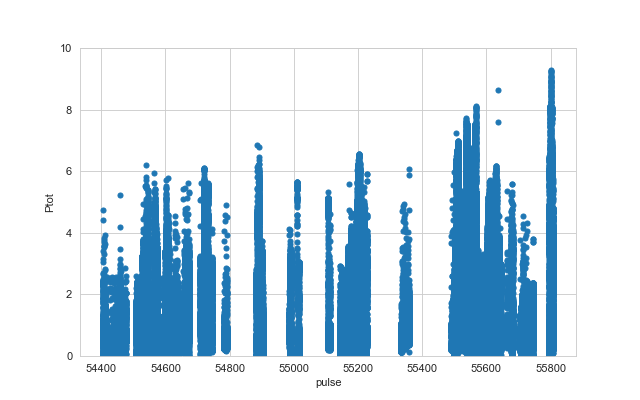

(0, 10)

In [30]:
fig, ax = plt.subplots()
data.plot(kind='scatter', x='pulse', y='Ptot', ax=ax)
ax.set_ylim(0,10)

# Separatrix Power

<IPython.core.display.Javascript object>


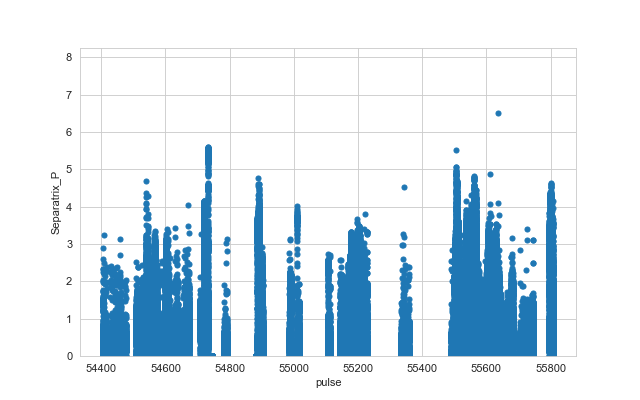

(0, 8.247197287645196)

In [31]:
fig, ax = plt.subplots()
data.plot(kind='scatter', x='pulse', y='Separatrix_P', ax=ax)
ax.set_ylim(bottom=0)

# 55226

In [32]:
_data = data.query('pulse == 55226')

<IPython.core.display.Javascript object>


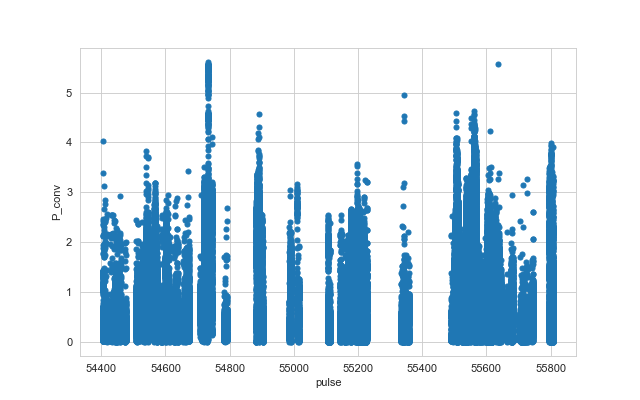

In [35]:
data.query('P_conv > 0').plot(kind='scatter', x='pulse', y='P_conv')

<IPython.core.display.Javascript object>


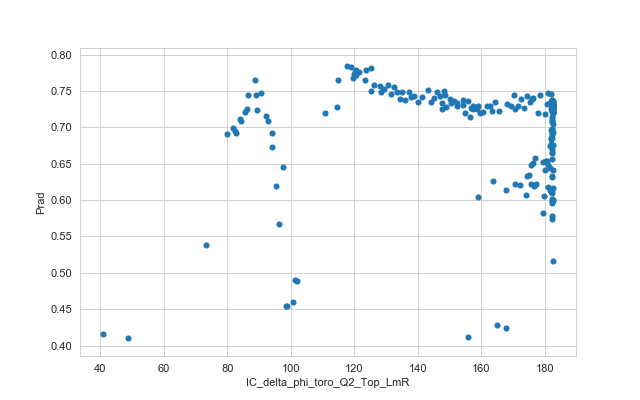

In [38]:
_data.query('IC_P_Q2 > 200').plot(kind='scatter', x='IC_delta_phi_toro_Q2_Top_LmR', y='Prad')


## 55215

In [ ]:
# keep only power larger than 200 kW
_data = data.query('pulse == 55215')
# Radiated power fraction
_data['Ptot'] = _data['LH_P_tot'] + _data['IC_P_tot']/1e3 
# increment de puissance rayonnée par rapport à la puissance rayonnée pendant la phase ohmique
_data['ratio_Pradincr'] =  np.abs(_data['Prad'] - 0.450)/_data['Ptot']*100   # 0.45 Prad during Ohmic

In [ ]:
fig, ax = plt.subplots()
_data.query('LH_P_tot > 0.2').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='LH1', s=50)
_data.query('IC_P_Q1 > 200').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='Q1', color='C1', s=50)
_data.query('IC_P_Q2 > 200').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='Q2', color='C2', s=50)
_data.query('IC_P_Q4 > 200').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='Q4', color='C3', s=50)
ax.legend(fontsize=14)
ax.set_ylabel('Fraction of radiated RF power [%]', fontsize=14)
ax.set_xlabel('RF power [MW]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST #55215', fontsize=14)

In [ ]:
fig, ax = plt.subplots()
ax.violinplot(_data.query('LH_P_tot > 0.2')['ratio_Pradincr'], [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(_data.query('IC_P_Q1 > 200')['ratio_Pradincr'], [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(_data.query('IC_P_Q2 > 200')['ratio_Pradincr'], [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(_data.query('IC_P_Q4 > 200')['ratio_Pradincr'], [3], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'LH1', '', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 - ', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
#ig.savefig('WEST_C4_IC_Rc_distribution_LSN_wo_LH.png', dpi=150)

# Coupling resistances

<IPython.core.display.Javascript object>


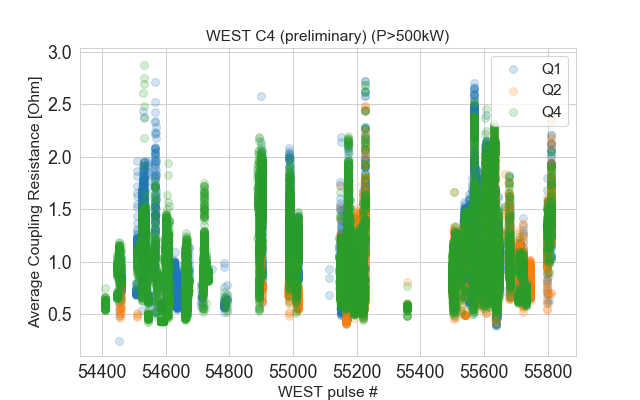

In [40]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_Q1 > 500').plot(kind='scatter', x='pulse', y='IC_Rc_Q1_avg', ax=ax, label='Q1', color='C0', s=50, alpha=0.2)
data.query('IC_P_Q2 > 500').plot(kind='scatter', x='pulse', y='IC_Rc_Q2_avg', ax=ax, label='Q2', color='C1', s=50, alpha=0.2)
data.query('IC_P_Q4 > 500').plot(kind='scatter', x='pulse', y='IC_Rc_Q4_avg', ax=ax, label='Q4', color='C2', s=50, alpha=0.2)
ax.legend(fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)

In [ ]:
fig.savefig('WEST_C4_IC_Rc_vs_pulse.png', dpi=150)

# Impact of Boronization

In [77]:
# Comparaison des sessions du mardi et vendredi IC only
# mardi post-boro
mardi09_03 = [54882, 54883, 54884, 54886, 54887, 54891, 54892, 54893, 54894, 54895, 54896, 54897,
              54898, 54899, 54900, 54902, 54903, 54904]             
mardi09_10 = [55014, 55015]
mardi09_17 = [55144, 55145, 55146, 55147, 55148, 55149, 55150, 55151]
# vendredi
vendredi09_13 = [55108, 55109, 55110, 55111, 55112, 55113, 55114]
vendredi09_20 = [55223, 55224, 55225, 55226, 55227]

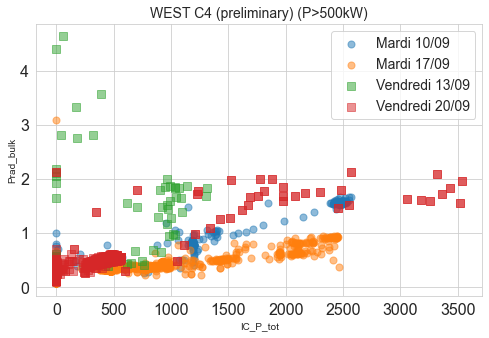

In [78]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_tot >= 0 and pulse in @mardi09_10').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Mardi 10/09', color='C0', s=50, alpha=0.5)
data.query('IC_P_tot >= 0 and pulse in @mardi09_17').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Mardi 17/09', color='C1', s=50, alpha=0.5)

data.query('IC_P_tot >= 0 and pulse in @vendredi09_13').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Vendredi 13/09', color='C2', s=50, marker='s', alpha=0.5)
data.query('IC_P_tot >= 0 and pulse in @vendredi09_20').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Vendredi 20/09', color='C3', s=50, marker='s', alpha=0.5)

ax.legend(fontsize=14)
#ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
#ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)

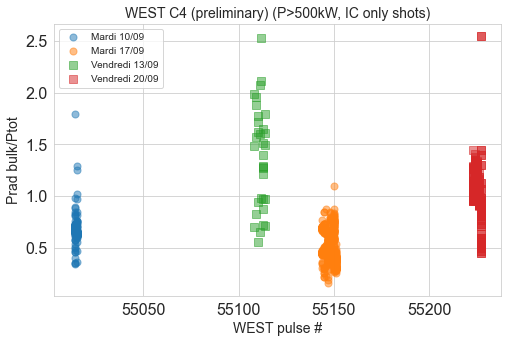

In [79]:
data['PradBulkMinusICtot'] = ( data['Prad_bulk']*1e3)/data['IC_P_tot']

fig, ax = plt.subplots()
data.query('IC_P_tot >= 400 and pulse in @mardi09_10').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Mardi 10/09', color='C0', s=50, alpha=0.5)
data.query('IC_P_tot >= 400 and pulse in @mardi09_17').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Mardi 17/09', color='C1', s=50, alpha=0.5)

data.query('IC_P_tot >= 400 and pulse in @vendredi09_13').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Vendredi 13/09', color='C2', s=50, marker='s', alpha=0.5)
data.query('IC_P_tot >= 400 and pulse in @vendredi09_20').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Vendredi 20/09', color='C3', s=50, marker='s', alpha=0.5)


ax.set_ylabel('Prad bulk/Ptot', fontsize=14)
ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW, IC only shots)', fontsize=14)
ax.grid(True)

In [80]:
fig.savefig('WEST_C4_Prad1.png', dpi=150)

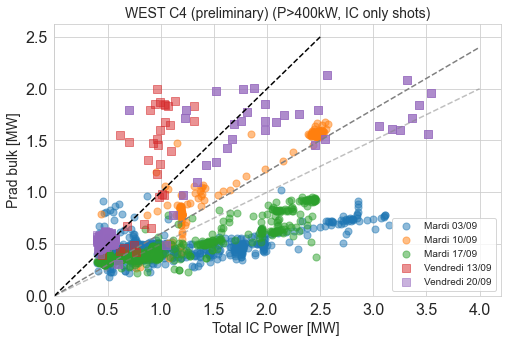

In [81]:
data['PradBulkMinusICtot'] = ( data['Prad_bulk']*1e3)/data['IC_P_tot']
data['IC_P_tot_MW'] = data['IC_P_tot']/1e3

fig, ax = plt.subplots()
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @mardi09_03').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Mardi 03/09', color='C0', s=50, alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @mardi09_10').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Mardi 10/09', color='C1', s=50, alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @mardi09_17').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Mardi 17/09', color='C2', s=50, alpha=0.5)

data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @vendredi09_13').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Vendredi 13/09', color='C3', s=50, marker='s', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @vendredi09_20').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Vendredi 20/09', color='C4', s=50, marker='s', alpha=0.5)

ax.plot([0,4], [0,0.5*4], ls='--', c='grey', alpha=0.5)
ax.plot([0,4], [0,0.6*4], ls='--', c='grey')
ax.plot([0,2.5], [0,2.5], ls='--', c='k')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_ylabel('Prad bulk [MW]', fontsize=14)
ax.set_xlabel('Total IC Power [MW] ', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>400kW, IC only shots)', fontsize=14)
ax.grid(True)
fig.savefig('WEST_C4_impact_boro.png', dpi=150)

# Phasing

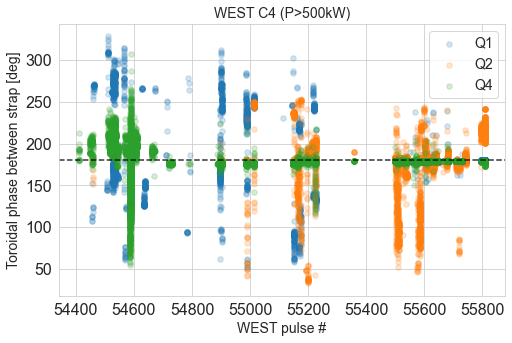

In [55]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_Q1 > 500').plot(kind='scatter', x='pulse', y='IC_delta_phi_toro_Q1_Bot_LmR', 
                                 ax=ax, label='Q1', color='C0', s=30, alpha=0.2)
data.query('IC_P_Q2 > 500').plot(kind='scatter', x='pulse', y='IC_delta_phi_toro_Q2_Top_LmR', 
                                 ax=ax, label='Q2', color='C1', s=30, alpha=0.2)
data.query('IC_P_Q4 > 500').plot(kind='scatter', x='pulse', y='IC_delta_phi_toro_Q4_Top_LmR', 
                                 ax=ax, label='Q4', color='C2', s=30, alpha=0.2)
ax.legend(fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (P>500kW)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)

In [56]:
fig.savefig('WEST_C4_IC_phase_toro.png', dpi=150)

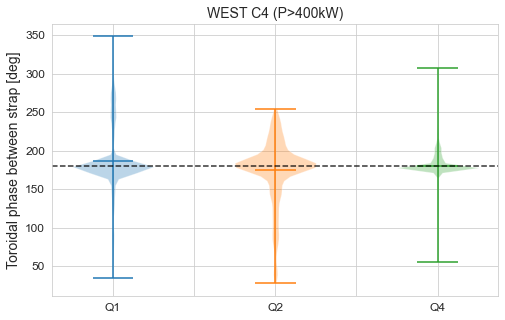

In [57]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 ')['IC_delta_phi_toro_Q1_Bot_LmR'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 ')['IC_delta_phi_toro_Q2_Top_LmR'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 ')['IC_delta_phi_toro_Q4_Top_LmR'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (P>400kW)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)
fig.savefig('WEST_C4_IC_Phase_toro_distribution.png', dpi=150)

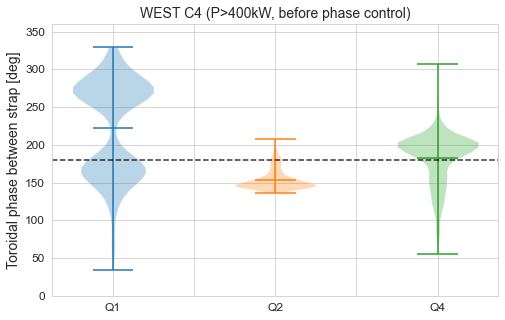

In [58]:
fig, ax = plt.subplots()
pulse_ref = 54626
ax.violinplot(data.query('IC_P_Q1 > 400 and pulse < @pulse_ref')['IC_delta_phi_toro_Q1_Bot_LmR'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < @pulse_ref')['IC_delta_phi_toro_Q2_Top_LmR'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and pulse < @pulse_ref')['IC_delta_phi_toro_Q4_Top_LmR'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (P>400kW, before phase control)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)
ax.set_ylim(0,360)
fig.savefig('WEST_C4_IC_Phase_toro_distribution_before_control.png', dpi=150)

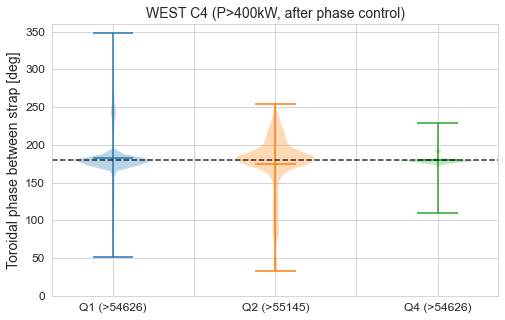

In [61]:
fig, ax = plt.subplots()
pulse_ref = 54626
pulse_ref_Q2 = 55145
ax.violinplot(data.query('IC_P_Q1 > 400 and pulse > @pulse_ref')['IC_delta_phi_toro_Q1_Bot_LmR'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > @pulse_ref_Q2')['IC_delta_phi_toro_Q2_Top_LmR'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and pulse > @pulse_ref')['IC_delta_phi_toro_Q4_Top_LmR'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', f'Q1 (>{pulse_ref})', '', f'Q2 (>{pulse_ref_Q2})', '', f'Q4 (>{pulse_ref})'), fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (P>400kW, after phase control)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)
ax.set_ylim(0,360)
fig.savefig('WEST_C4_IC_Phase_toro_distribution_after_control.png', dpi=150)

# Phase Control Relevance for coupling

In [62]:
filtered_data = data.query('IC_P_Q4 > 100 and pulse > 54626 and Ip < 600 and Xpoint == "LSN" and IC_P_Q1 < 100 and IC_P_Q2 < 100')
# keeping only relevant data
#filtered_data = filtered_data[['nl', 'frad', 'IC_delta_phi_toro_Q4_Top_LmR', 'IC_P_Q4', 'IC_Rc_Q4_avg']]

In [63]:
filtered_data['phase_avg_Q1'] = filtered_data[['IC_delta_phi_toro_Q4_Bot_LmR', 
                                               'IC_delta_phi_toro_Q4_Top_LmR']].mean(axis=1)

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


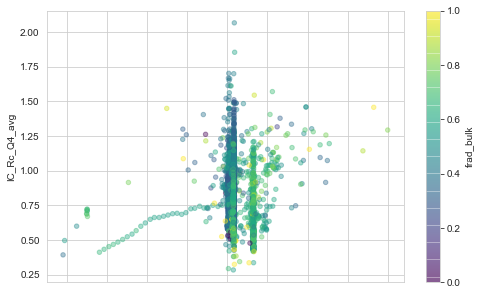

In [65]:
filtered_data.plot(kind='scatter', 
                   x='IC_delta_phi_toro_Q4_Top_LmR', y='IC_Rc_Q4_avg',
     c='frad_bulk', vmin=0, vmax=1, colormap='viridis', alpha=0.4)

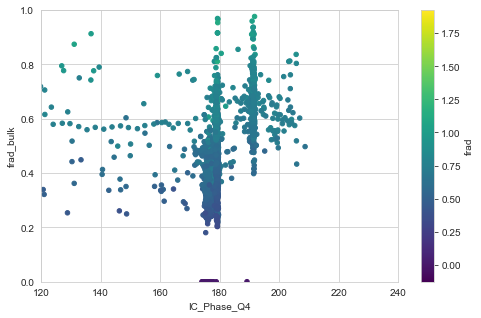

In [67]:
fig, ax = plt.subplots()
filtered_data.plot(kind='scatter', ax=ax, 
            x='IC_Phase_Q4', y='frad_bulk', 
            xlim=(180-60, 180+60), ylim=(0,1), c='frad', cmap='viridis')

# LH and IC

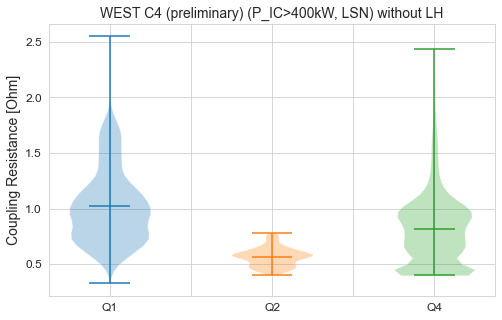

In [73]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) without LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ylim = ax.set_ylim()
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_wo_LH.png', dpi=150)

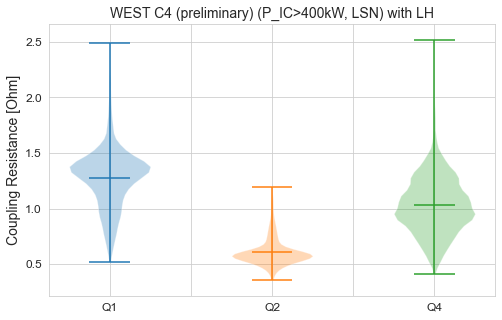

In [74]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) with LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_w_LH.png', dpi=150)

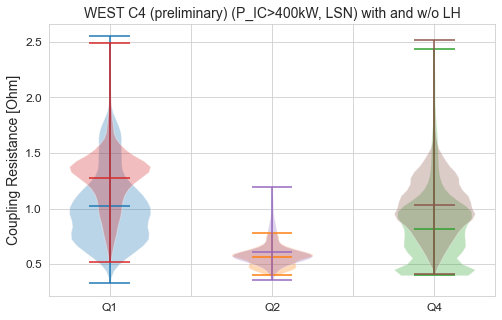

In [75]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) with and w/o LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_w-and-wo_LH.png', dpi=150)

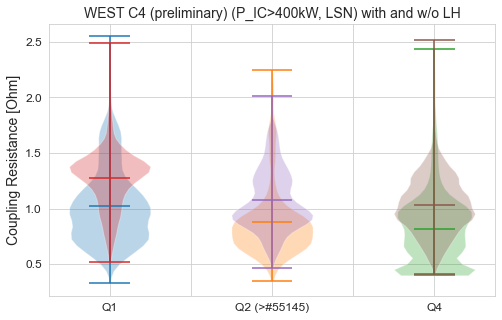

In [76]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse > 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse > 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2 (>#55145)', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) with and w/o LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_w-and-wo_LH.png', dpi=150)

# Flash on Q4

In [133]:
matched_pulses = np.array([54512,
 54533, 54534, 54566, 54603, 54605, 54606, 54607, 54609, 54610, 54611, 54612, 54631, 54674, 54709, 54721, 54887,
 54986, 55108, 55144, 55147, 55174, 55175, 55196, 55200, 55202, 55215, 55219, 55220, 55227, 55334, 55335, 55336,
 55337, 55340, 55341, 55342, 55345, 55509, 55589, 55603, 55604, 55605, 55606, 55607, 55609, 55610, 55612, 55613,
 55616, 55628, 55629, 55630, 55631, 55633, 55643, 55665, 55677, 55679, 55681, 55682, 55799, 55800, 55802, 55803,
 55805, 55809])

In [134]:
# get only pulses where flash of lights on Q4 have been observed on the camera 
data_occurences = data[data['pulse'].isin(matched_pulses)]

In [135]:
len(data_occurences['pulse'].unique())

67

In [136]:
len(data['pulse'].unique())

361

In [137]:
67/361*100

18.559556786703602

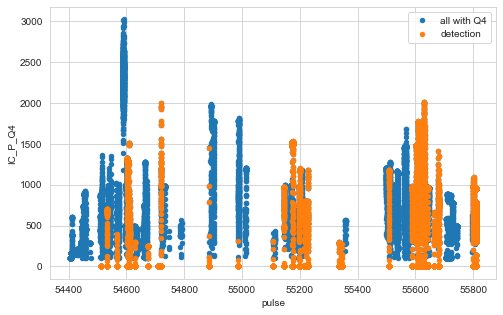

In [128]:
fig, ax = plt.subplots()
data.query('IC_P_Q4>100').plot(ax=ax, kind='scatter', x='pulse', y='IC_P_Q4', color='C0', label='all with Q4')
data_occurences.plot(ax=ax, kind='scatter', x='pulse', y='IC_P_Q4', color='C1', label='detection')

In [129]:
fig.savefig('Q4_flashes_detection.png', dpi=150)

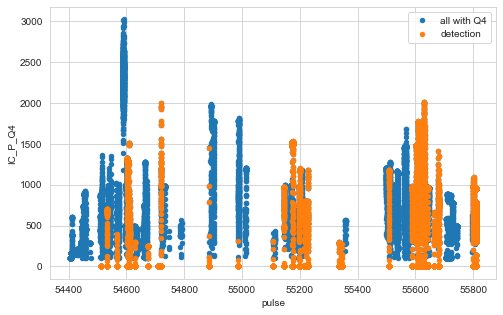

In [153]:
fig, ax = plt.subplots()
data.query('IC_P_Q4>100').plot(ax=ax, kind='scatter', x='pulse', y='IC_P_Q4', color='C0', label='all with Q4')
data_occurences.plot(ax=ax, kind='scatter', x='pulse', y='IC_P_Q4', color='C1', label='detection')


In [149]:
data_occurences['pulse'].corr(data['pulse'])

1.0